In [1]:
import numpy as np
import os
import cv2
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import ConvLSTM2D, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
# Parameters
IMG_SIZE = (120, 120)  
BATCH_SIZE = 4         
EPOCHS = 20
MAX_FRAMES = 16   
MAX_VIDEOS_PER_CLASS = 600

In [3]:
def extract_frames_from_video(video_path, frame_rate=5, max_frames=MAX_FRAMES):
    cap = cv2.VideoCapture(video_path)
    frames = []
    count = 0
    success = True
    while success:
        success, frame = cap.read()
        if success and count % frame_rate == 0:
            frame = cv2.resize(frame, IMG_SIZE)
           # frame = frame/255.0
            frames.append(frame)
        count += 1
        if len(frames) >= max_frames:  # Limit frames to `max_frames`
            break
    cap.release()

    # If the video has fewer frames, pad with zeros
    if len(frames) < max_frames:
        padding = np.zeros((max_frames - len(frames), IMG_SIZE[0], IMG_SIZE[1], 3), dtype=np.float32)
        frames.extend(padding)
    return np.array(frames[:max_frames], dtype=np.float32)

In [4]:
def load_video_paths(video_dir, label, max_videos=MAX_VIDEOS_PER_CLASS):
    video_paths = []
    labels = []
    for i, video_file in enumerate(os.listdir(video_dir)):
        if max_videos and i >= max_videos:
            break
        video_path = os.path.join(video_dir, video_file)
        video_paths.append(video_path)
        labels.append(label)
    return video_paths, labels

In [5]:
violent_video_paths, violent_labels = load_video_paths('/kaggle/input/violence-nonviolence/Real_Life_Violence_Dataset/Violence', label=1)
non_violent_video_paths, non_violent_labels = load_video_paths('/kaggle/input/violence-nonviolence/Real_Life_Violence_Dataset/NonViolence', label=0)

In [6]:
video_paths = violent_video_paths + non_violent_video_paths
labels = violent_labels + non_violent_labels

In [7]:

train_paths, test_paths, train_labels, test_labels = train_test_split(video_paths, labels, test_size=0.2, random_state=42)


train_videos = np.array([extract_frames_from_video(path) for path in train_paths])
test_videos = np.array([extract_frames_from_video(path) for path in test_paths])

In [8]:
# Convert labels to numpy arrays
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

In [9]:

def create_model():
    # Define the input shape (sequence of frames)
    input_shape = (MAX_FRAMES, IMG_SIZE[0], IMG_SIZE[1], 3)
    
    # Feature extraction using ConvLSTM2D
    model = Sequential()
    model.add(ConvLSTM2D(filters=64, kernel_size=(3, 3), input_shape=input_shape,
                         padding='same', return_sequences=True))
    model.add(Dropout(0.5))  # Dropout layer to prevent overfitting
    model.add(ConvLSTM2D(filters=32, kernel_size=(3, 3), padding='same', return_sequences=False))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))  # Dropout layer to prevent overfitting
    model.add(Dense(2, activation='softmax'))  # Output layer for binary classification

    return model

In [10]:

model = create_model()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:

model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, 16, 120, 120,   │       154,624 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 120, 120,   │             0 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 120, 120, 32)   │       110,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 267,586 (1.02 MB)

 Trainable params: 267,586 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:

checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

In [14]:
history = model.fit(train_videos, train_labels, epochs=50, batch_size=BATCH_SIZE,
                    validation_data=(test_videos, test_labels), callbacks=[checkpoint])

Epoch 1/50


I0000 00:00:1731147091.158030    4936 service.cc:145] XLA service 0x5a4304d31270 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731147091.158074    4936 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1731147091.158079    4936 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1731147099.873532    4936 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_fusion_1', 916 bytes spill stores, 916 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_add_multiply_reduce_fusion_1', 840 bytes spill stores, 840 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_fusion', 916 bytes spill stores, 916 bytes spill loads

I0000 00:00:1731147099.888114    4936 device_compiler.h:188] Compiled cluster using XLA!  This line

240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 583ms/step - accuracy: 0.5490 - loss: 0.6860
Epoch 1: val_accuracy improved from -inf to 0.69167, saving model to best_model.keras
240/240 ━━━━━━━━━━━━━━━━━━━━ 163s 631ms/step - accuracy: 0.5491 - loss: 0.6859 - val_accuracy: 0.6917 - val_loss: 0.5900
Epoch 2/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 602ms/step - accuracy: 0.6909 - loss: 0.6015
Epoch 2: val_accuracy improved from 0.69167 to 0.72917, saving model to best_model.keras
240/240 ━━━━━━━━━━━━━━━━━━━━ 152s 635ms/step - accuracy: 0.6909 - loss: 0.6014 - val_accuracy: 0.7292 - val_loss: 0.5431
Epoch 3/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 602ms/step - accuracy: 0.7508 - loss: 0.5246
Epoch 3: val_accuracy did not improve from 0.72917
240/240 ━━━━━━━━━━━━━━━━━━━━ 152s 635ms/step - accuracy: 0.7508 - loss: 0.5246 - val_accuracy: 0.7292 - val_loss: 0.5859
Epoch 4/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 602ms/step - accuracy: 0.7829 - loss: 0.4694
Epoch 4: val_accuracy did not improve from 0.72917
240/240 ━━━━━━━━━━━

In [15]:

test_loss, test_accuracy = model.evaluate(test_videos, test_labels)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.8386 - loss: 0.3938
Test Accuracy: 85.00%
Test Loss: 0.3787


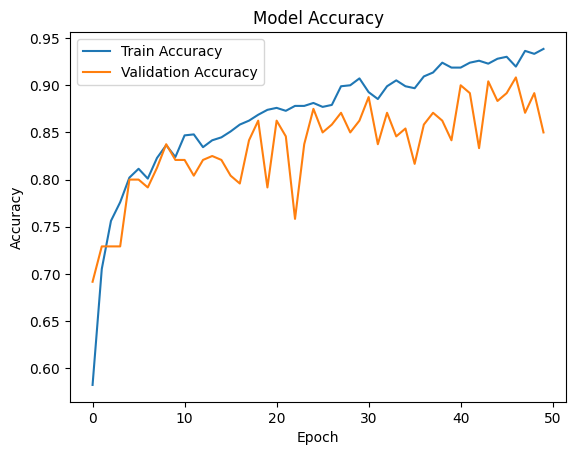

In [16]:

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

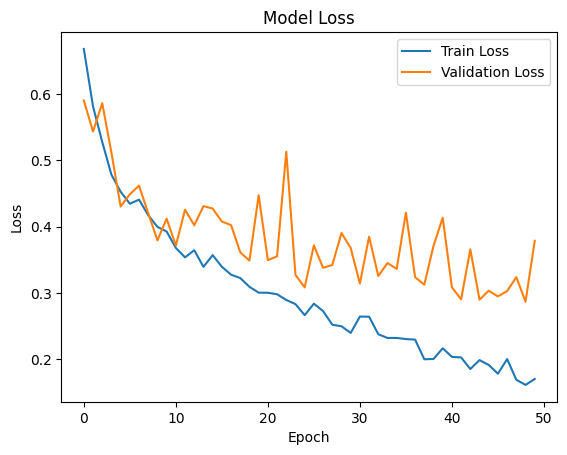

In [17]:

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()